# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [2]:
pip install matplotlib-venn


^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject as dp


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

In [ ]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


Import your data, either through an API or manually, and load it. 

In [ ]:
# The DST API wrapper
%pip install git+https://github.com/alemartinello/dstapi


  Cloning https://github.com/alemartinello/dstapi to c:\users\bruger\appdata\local\temp\pip-req-build-xndc66_x
  Resolved https://github.com/alemartinello/dstapi to commit d9eeb5a82cbc70b7d63b2ff44d92632fd77123a4
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/alemartinello/dstapi 'C:\Users\Bruger\AppData\Local\Temp\pip-req-build-xndc66_x'


In [ ]:
# A wrapper for multiple APIs with a pandas interface
%pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [19]:
import numpy as np
import pandas as pd
import datetime

import pandas_datareader # install with `pip install pandas-datareader`
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

In [20]:
ind = DstApi('PRIS111') 

In [21]:
tabsum = ind.tablesummary(language='en')
display(tabsum)

Table PRIS111: Consumer price index by commodity group, unit and time
Last update: 2024-03-11T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,VAREGR,385,000000,"00 Consumer price index, total",151000,15.1 Overall Consumer Price Index excl. energy,False
1,ENHED,3,100,Index,300,Percentage change compared to same month the y...,False
2,Tid,278,2001M01,2001M01,2024M02,2024M02,True


In [22]:
# The available values for a each variable: 
for variable in tabsum['variable name']:
    print(variable+':')
    display(ind.variable_levels(variable, language='en'))

VAREGR:


,id,text
0,000000,"00 Consumer price index, total"
1,010000,01 Food and non-alcoholic beverages
2,011000,01.1 Food
3,011100,01.1.1 Bread and cereals
4,011110,01.1.1.1 Rice
...,...,...
380,127030,12.7.0.3 Funeral services
381,131000,13.1 Goods (total)
382,132000,13.2 Services (total)
383,141000,14.1 Overall Consumer Price Index - excl. ener...


ENHED:


,id,text
0,100,Index
1,200,Percentage change compared to previous month (...
2,300,Percentage change compared to same month the y...


Tid:


,id,text
0,2001M01,2001M01
1,2001M02,2001M02
2,2001M03,2001M03
3,2001M04,2001M04
4,2001M05,2001M05
...,...,...
273,2023M10,2023M10
274,2023M11,2023M11
275,2023M12,2023M12
276,2024M01,2024M01


In [23]:
# The _define_base_params -method gives us a nice template (selects all available data)
params = ind._define_base_params(language='en')

params

{'table': 'pris111',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'VAREGR', 'values': ['*']},
  {'code': 'ENHED', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

We identify variables to be used

In [24]:
variables = params['variables'] # Returns a view, that we can edit
variables[0]['values'] = ['000000']
variables[1]['values'] =['300']
variables[2]['values'] = ['2007M12','2008M12','2009M12','2010M12','2011M12','2012M12','2013M12', '2014M12', '2015M12', '2016M12', '2017M12', '2018M12', '2019M12', '2020M12', '2021M12', '2022M12']
params

{'table': 'pris111',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'VAREGR', 'values': ['000000']},
  {'code': 'ENHED', 'values': ['300']},
  {'code': 'Tid',
   'values': ['2007M12',
    '2008M12',
    '2009M12',
    '2010M12',
    '2011M12',
    '2012M12',
    '2013M12',
    '2014M12',
    '2015M12',
    '2016M12',
    '2017M12',
    '2018M12',
    '2019M12',
    '2020M12',
    '2021M12',
    '2022M12']}]}

Now we load the data from dst via the api using the options specified in the param dictionary 

In [25]:
inc_api = ind.get_data(params=params)
inc_api.head(20)

,VAREGR,ENHED,TID,INDHOLD
0,"00 Consumer price index, total",Percentage change compared to same month the y...,2007M12,2.3
1,"00 Consumer price index, total",Percentage change compared to same month the y...,2008M12,2.4
2,"00 Consumer price index, total",Percentage change compared to same month the y...,2009M12,1.4
3,"00 Consumer price index, total",Percentage change compared to same month the y...,2010M12,2.8
4,"00 Consumer price index, total",Percentage change compared to same month the y...,2011M12,2.4
5,"00 Consumer price index, total",Percentage change compared to same month the y...,2012M12,2.1
6,"00 Consumer price index, total",Percentage change compared to same month the y...,2013M12,0.7
7,"00 Consumer price index, total",Percentage change compared to same month the y...,2014M12,0.4
8,"00 Consumer price index, total",Percentage change compared to same month the y...,2015M12,0.4
9,"00 Consumer price index, total",Percentage change compared to same month the y...,2016M12,0.5


Data is now ready for cleaning and renaming

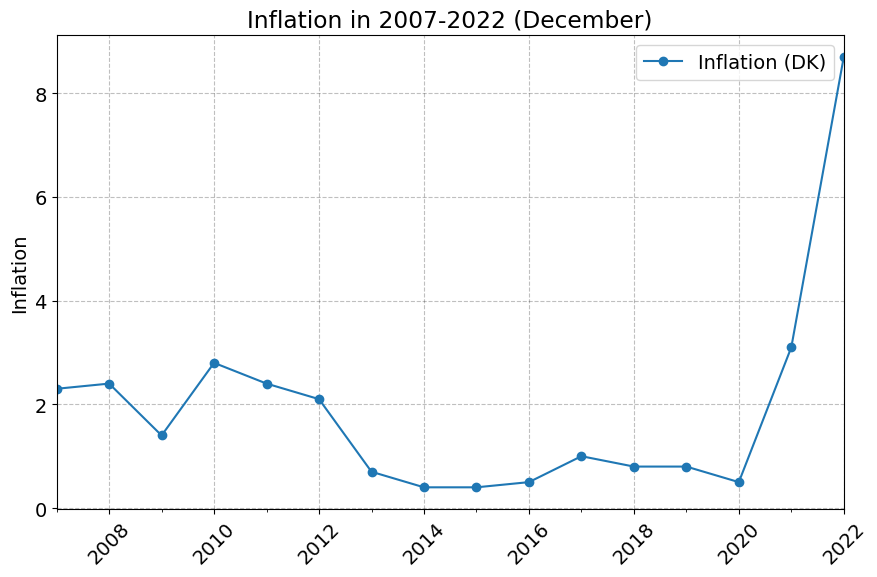

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Defining the data
dates_inflation = ['2007M12','2008M12','2009M12','2010M12','2011M12','2012M12','2013M12','2014M12', '2015M12', '2016M12', '2017M12', '2018M12', '2019M12', '2020M12', '2021M12', '2022M12']
inflation_values = [2.3, 2.4,1.4, 2.8, 2.4, 2.1, 0.7, 0.4, 0.4, 0.5, 1.0, 0.8, 0.8, 0.5, 3.1, 8.7]

# Creating a pandas DataFrame
infla_dk = pd.DataFrame({'Inflation (DK)': inflation_values}, index=pd.to_datetime(dates_inflation, format='%YM%m'))

# Plotting
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(1,1,1)
infla_dk.plot(ax=ax, legend=True, marker='o')

ax.legend(frameon=True)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Inflation in 2007-2022 (December)')
ax.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()

We observe inflation in Denmark in the period 2013-23. Inflation was relatively stagnant in December 2013-2021. In 2013, inflation was at 0.7 pct. This was followed by a decrease to 0.4 pct. in 2014, and it remained unchanged in 2015. There was an increase to 0.5 pct. in 2016, which was followed by a larger increase to 1.0 pct in 2017. Inflation in 2018-21 was 0.8 pct, 0.8 pct, 0.5 pct. and 3.1 respectively. A relatively large increase in inflation to 8.7 pct. was observed in 2022 was mostly due to changes in prices in residential use, electricity, and heating. The relatively large decrease to 0.7 pct. in December 2023 is greatly due to decreasing energy prices.

NY

In [27]:
ind = DstApi('KAS301')

In [15]:
tabsum = ind.tablesummary(language='en')
display(tabsum)

Table KAS301: Average number of employed by region, industry (DB07), socioeconomic status, age, sex, period and time
Last update: 2023-11-24T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,OMRÅDE,117,000,All Denmark,950,Outside Denmark,False
1,BRANCHE07,38,TOT,"TOT Industry, total",X,X Activity not stated,False
2,SOCIO,9,02,Employed total,40,"Employees, not specified",False
3,ALDER,14,TOT,"Age, total",67-,67 years and over,False
4,KOEN,3,TOT,Total,K,Women,False
5,PERIODE,5,1,Whole year,K4,4. quarter,False
6,Tid,15,2008,2008,2022,2022,True


In [16]:
# The available values for a each variable: 
for variable in tabsum['variable name']:
    print(variable+':')
    display(ind.variable_levels(variable, language='en'))

OMRÅDE:


,id,text
0,000,All Denmark
1,084,Region Hovedstaden
2,01,Province Byen København
3,101,Copenhagen
4,147,Frederiksberg
...,...,...
112,840,Rebild
113,787,Thisted
114,820,Vesthimmerlands
115,851,Aalborg


BRANCHE07:


,id,text
0,TOT,"TOT Industry, total"
1,A,"A Agriculture, forestry and fishing"
2,B,B Mining and quarrying
3,CA,"CA Manufacture of food products, beverages and..."
4,CB,CB Textiles and leather products
5,CC,CC Wood and paper products and printing
6,CD,CD Oil refinery etc.
7,CE,CE Manufacture of chemicals
8,CF,CF Pharmaceuticals
9,CG,"CG Manufacture of plastic, glass and concrete"


SOCIO:


,id,text
0,02,Employed total
1,05,Self-employed
2,10,Assisting spouses
3,15,"Employees, managers"
4,20,Employees - upper level
5,25,Employees - medium level
6,30,Employees - basic level
7,35,Other employees
8,40,"Employees, not specified"


ALDER:


,id,text
0,TOT,"Age, total"
1,-16,Under 16 years
2,16-19,16-19 years
3,20-24,20-24 years
4,25-29,25-29 years
5,30-34,30-34 years
6,35-39,35-39 years
7,40-44,40-44 years
8,45-49,45-49 years
9,50-54,50-54 years


KOEN:


,id,text
0,TOT,Total
1,M,Men
2,K,Women


PERIODE:


,id,text
0,1,Whole year
1,K1,1. quarter
2,K2,2. quarter
3,K3,3. quarter
4,K4,4. quarter


Tid:


,id,text
0,2008,2008
1,2009,2009
2,2010,2010
3,2011,2011
4,2012,2012
5,2013,2013
6,2014,2014
7,2015,2015
8,2016,2016
9,2017,2017


In [17]:
# The _define_base_params -method gives us a nice template (selects all available data)
params = ind._define_base_params(language='en')

params

{'table': 'kas301',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'OMRÅDE', 'values': ['*']},
  {'code': 'BRANCHE07', 'values': ['*']},
  {'code': 'SOCIO', 'values': ['*']},
  {'code': 'ALDER', 'values': ['*']},
  {'code': 'KOEN', 'values': ['*']},
  {'code': 'PERIODE', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [18]:
variables = params['variables'] # Returns a view, that we can edit
#Område
variables[0]['values'] = ['000']
#branche
variables[1]['values'] = ['0']
#socio 
variables[2]['values'] = ['02']
#alder
#variables[3]['values'] = ['02']
#periode
variables[4]['values'] = ['1']
#tid
variables[5]['values'] = ['1']
params

{'table': 'kas301',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'OMRÅDE', 'values': ['000']},
  {'code': 'BRANCHE07', 'values': ['0']},
  {'code': 'SOCIO', 'values': ['02']},
  {'code': 'ALDER', 'values': ['*']},
  {'code': 'KOEN', 'values': ['1']},
  {'code': 'PERIODE', 'values': ['1']},
  {'code': 'Tid', 'values': ['*']}]}

In [62]:
ind1 = DstApi('AULP01')


In [63]:
tabsum3 = ind1.tablesummary(language='en')  # Assuming 'ind1' is your DataFrame

# Check the current column names
print(tabsum3.columns)

# Rename the columns
tabsum3.rename(columns={'OMRÅDE': 'OMRAADE', 'KØN': 'KOEN'}, inplace=True)

# Display the DataFrame to verify the changes
print(tabsum3.head())


Table AULP01: Full-time unemployed persons in per cent of the labour force by region, age, sex and time
Last update: 2023-04-14T08:00:00
Index(['variable name', '# values', 'First value', 'First value label',
       'Last value', 'Last value label', 'Time variable'],
      dtype='object')
  variable name  # values First value First value label Last value  \
0        OMRÅDE       117         000       All Denmark        997   
1         ALDER        10         TOT        Age, total       6099   
2           KØN         3         TOT             Total          K   
3           Tid        16        2007              2007       2022   

   Last value label  Time variable  
0            Abroad          False  
1  60 year and over          False  
2             Women          False  
3              2022           True  


In [64]:
# The available values for a each variable: 
for variable in tabsum3['variable name']:
    print(variable+':')
    display(ind1.variable_levels(variable, language='en'))

OMRÅDE:


,id,text
0,000,All Denmark
1,084,Region Hovedstaden
2,01,Province Byen København
3,101,Copenhagen
4,147,Frederiksberg
...,...,...
112,787,Thisted
113,820,Vesthimmerlands
114,851,Aalborg
115,998,Unknown municipality


ALDER:


,id,text
0,TOT,"Age, total"
1,16-24,16-24 years
2,25-29,25-29 years
3,30-34,30-34 years
4,35-39,35-39 years
5,40-44,40-44 years
6,45-49,45-49 years
7,50-54,50-54 years
8,55-59,55-59 years
9,6099,60 year and over


KØN:


,id,text
0,TOT,Total
1,M,Men
2,K,Women


Tid:


,id,text
0,2007,2007
1,2008,2008
2,2009,2009
3,2010,2010
4,2011,2011
5,2012,2012
6,2013,2013
7,2014,2014
8,2015,2015
9,2016,2016


In [65]:
# The _define_base_params -method gives us a nice template (selects all available data)
params = ind1._define_base_params(language='en')

params

{'table': 'aulp01',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'OMRÅDE', 'values': ['*']},
  {'code': 'ALDER', 'values': ['*']},
  {'code': 'KØN', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [66]:
params={'table': 'aulp01',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'OMRÅDE', 'values': ['000']},
  {'code': 'ALDER', 'values': ['TOT']},
  {'code': 'KØN', 'values': ['M', 'K', 'TOT']},
  {'code': 'Tid', 'values': ['>=2007']}]}

params

{'table': 'aulp01',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'OMRÅDE', 'values': ['000']},
  {'code': 'ALDER', 'values': ['TOT']},
  {'code': 'KØN', 'values': ['M', 'K', 'TOT']},
  {'code': 'Tid', 'values': ['>=2007']}]}

In [33]:
ind1_1=ind1.get_data(params=params)
# Rename the column from 'KØN' to 'KOEN'
ind1_1.rename(columns={'KØN': 'KOEN'}, inplace=True)
# Rename the column from 'KØN' to 'KOEN'
ind1_1.rename(columns={'OMRÅDE': 'OMRAADE'}, inplace=True)

ind1_1.head(100)

,OMRAADE,ALDER,KOEN,TID,INDHOLD
0,All Denmark,"Age, total",Women,2007,4.4
1,All Denmark,"Age, total",Men,2007,2.9
2,All Denmark,"Age, total",Total,2007,3.6
3,All Denmark,"Age, total",Women,2008,2.9
4,All Denmark,"Age, total",Men,2008,2.4
5,All Denmark,"Age, total",Total,2008,2.6
6,All Denmark,"Age, total",Women,2009,4.1
7,All Denmark,"Age, total",Men,2009,5.5
8,All Denmark,"Age, total",Total,2009,4.8
9,All Denmark,"Age, total",Women,2010,5.1


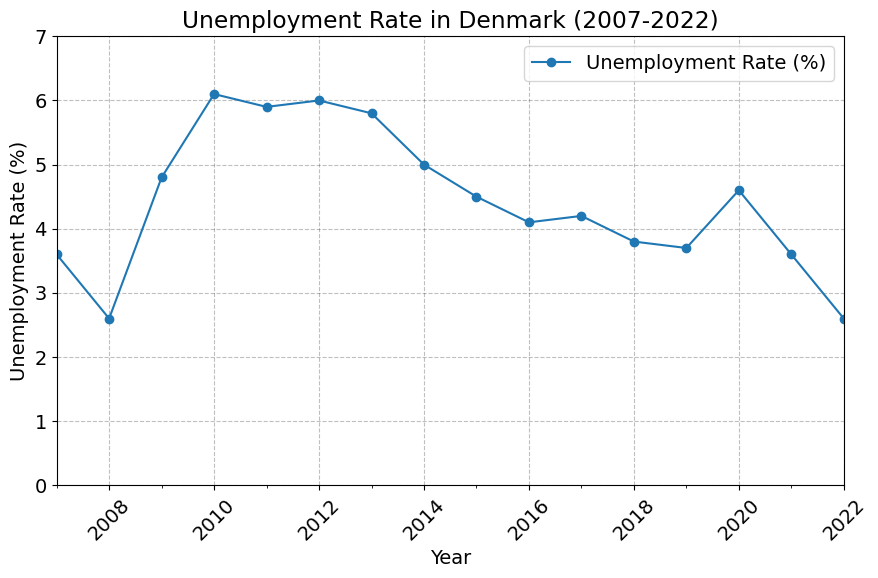

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Defining the data
dates_unemployment = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
umemp_values = [3.6, 2.6, 4.8, 6.1, 5.9, 6.0, 5.8, 5.0, 4.5, 4.1, 4.2, 3.8, 3.7, 4.6, 3.6, 2.6]

# Creating a pandas DataFrame with correct date parsing
umemp_dk = pd.DataFrame({'Unemployment Rate (%)': umemp_values}, index=pd.to_datetime(dates_unemployment, format='%Y'))

# Plotting
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(1, 1, 1)
umemp_dk.plot(ax=ax, legend=True, marker='o', color='tab:blue')

ax.legend(frameon=True)
ax.set_xlabel('Year')
ax.set_ylabel('Unemployment Rate (%)')
ax.set_title('Unemployment Rate in Denmark (2007-2022)')
ax.grid(True)

plt.xticks(rotation=45)
plt.ylim(0, 7.0)  # Setting y-axis limits as requested
plt.tight_layout()
plt.show()


Merging

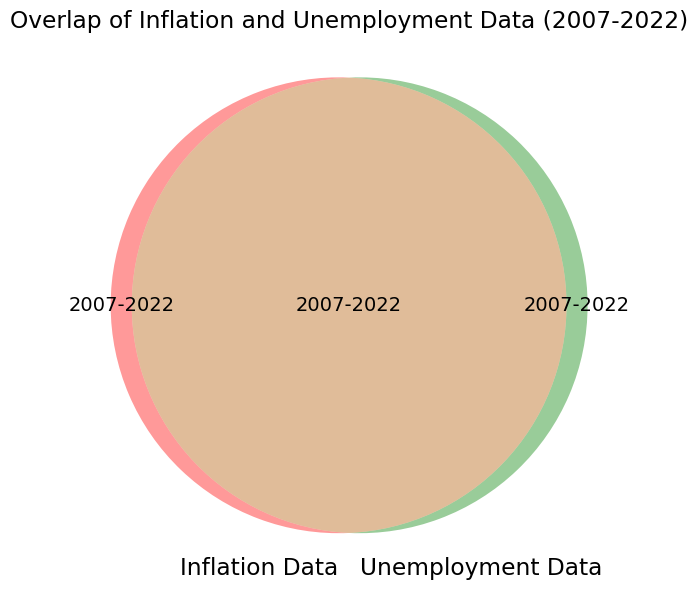

In [35]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
# Since both datasets cover the same years, we'll consider that as a complete overlap.
# The 'subsets' values are illustrative and not based on actual numerical data from the datasets.
v = venn2(subsets=(1, 1, 16), set_labels=('Inflation Data', 'Unemployment Data'))

# Adjusting the labels to reflect the conceptual overlap
v.get_label_by_id('10').set_text('2007-2022')  # Years covered by Inflation Data only (conceptual)
v.get_label_by_id('01').set_text('2007-2022')  # Years covered by Unemployment Data only (conceptual)
v.get_label_by_id('11').set_text('2007-2022')  # Years covered by both datasets

plt.title('Overlap of Inflation and Unemployment Data (2007-2022)')
plt.show()


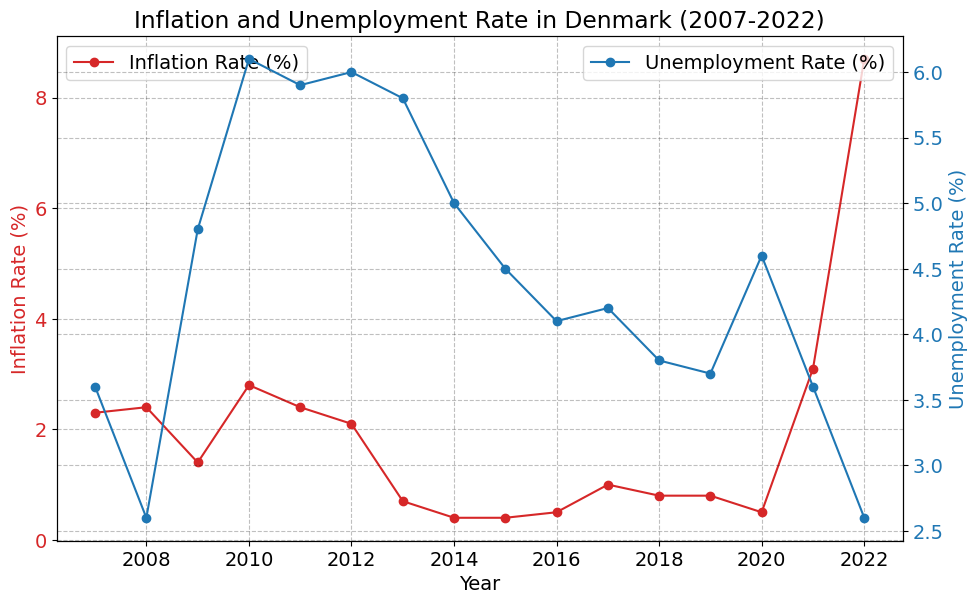

In [36]:
# Correcting the date format for the unemployment data by removing '-01-01'

# Removing '-01-01' from each date string in the unemployment data to match the '%Y' format
dates_unemployment_corrected = [date[:4] for date in dates_unemployment]  # Takes only the first 4 characters (the year)

# Recreating the unemployment DataFrame with the corrected dates
umemp_dk_corrected = pd.DataFrame({'Unemployment Rate (%)': umemp_values}, index=pd.to_datetime(dates_unemployment_corrected, format='%Y'))

# Merging the corrected inflation data and unemployment data into one plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Inflation Rate (%)', color=color)
ax1.plot(inflation_df_corrected.index, inflation_df_corrected['Inflation (DK)'], color=color, marker='o', label='Inflation Rate (%)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Unemployment Rate (%)', color=color)
ax2.plot(umemp_dk_corrected.index, umemp_dk_corrected['Unemployment Rate (%)'], color=color, marker='o', label='Unemployment Rate (%)')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Inflation and Unemployment Rate in Denmark (2007-2022)')
plt.show()



PRØVER AT MERGE SOM I PS4

In [99]:
columns_dict = {}
columns_dict['OMRÅDE'] = 'variable'
columns_dict['ALDER'] = 'Age'
columns_dict['KØN'] = 'unit'
columns_dict['TID'] = 'year'
columns_dict['INDHOLD'] = 'value'

var_dict = {} # var is for variable
var_dict['I alt'] = 'Total'
var_dict['Mænd'] = 'Men'
var_dict['Kvinder'] = 'Women'


unit_dict = {}
unit_dict['Alder'] = 'Age'


In [100]:
# hint, 
nah1_api = DstApi('PRIS111') 
# hint, 
params = nah1_api._define_base_params(language='en')

nah1 = nah1_api.get_data(params)

In [101]:
nah1

,VAREGR,ENHED,TID,INDHOLD
0,05.3.2.3 Irons,Percentage change compared to same month the y...,2006M07,..
1,05.3.2.4 Toasters and grills,Index,2006M07,..
2,05.3.2.4 Toasters and grills,Percentage change compared to previous month (...,2006M07,..
3,05.3.2.4 Toasters and grills,Percentage change compared to same month the y...,2006M07,..
4,05.3.2.9 Other small electric household applia...,Index,2006M07,..
...,...,...,...,...
321085,14.1 Overall Consumer Price Index - excl. ener...,Percentage change compared to previous month (...,2020M12,-0.4
321086,14.1 Overall Consumer Price Index - excl. ener...,Percentage change compared to same month the y...,2020M12,1.0
321087,15.1 Overall Consumer Price Index excl. energy,Index,2020M12,104.1
321088,15.1 Overall Consumer Price Index excl. energy,Percentage change compared to previous month (...,2020M12,-0.4


In [103]:
# hint,
nah1.rename(columns=columns_dict,inplace=True)
nah1

for key,value in var_dict.items():
    nah1.variable.replace(key,value,inplace=True)

nah1

for key,value in unit_dict.items():
    nah1.unit.replace(key,value,inplace=True)

nah1

AttributeError: 'DataFrame' object has no attribute 'variable'

NEXT TABLE

In [83]:
FT_api = DstApi('AULP01')
params = FT_api._define_base_params(language='en')
params['variables'][0]['values'] = ['000']
params['variables'][1]['values'] = ['TOT']
params['variables'][2]['values'] = ['M', 'K', 'TOT']
params['variables'][3]['values'] = ['2007','2008','2009','2010','2011','2012','2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']

params 
## 000 is the code for all of Denmark, this can be seen by using: FT_api.variable_levels('HOVEDDELE', language='en')
pop = FT_api.get_data(params=params)

pop.rename(columns={'OMRÅDE':'Omraade', 'ALDER':'Total', 'KØN':'Gender', 'TID':'Year'},inplace=True)
pop =  pop.loc[:,['Omraade','Total', 'Gender', 'Year']]
pop.head()

,Omraade,Total,Gender,Year
0,All Denmark,"Age, total",Women,2007
1,All Denmark,"Age, total",Men,2007
2,All Denmark,"Age, total",Total,2007
3,All Denmark,"Age, total",Women,2008
4,All Denmark,"Age, total",Men,2008


Rabiahs kode 

importing data from an API

In [ ]:
kas = DstApi('KAS301')

Cleaning data

In [ ]:

tabsum_kas= kas.tablesummary(language='en')
display(tabsum_kas)
for var in tabsum_kas['variable name']:
    print(var+':')
    display(kas.variable_levels(var, language='en'))

Table KAS301: Average number of employed by region, industry (DB07), socioeconomic status, age, sex, period and time
Last update: 2023-11-24T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,OMRÅDE,117,000,All Denmark,950,Outside Denmark,False
1,BRANCHE07,38,TOT,"TOT Industry, total",X,X Activity not stated,False
2,SOCIO,9,02,Employed total,40,"Employees, not specified",False
3,ALDER,14,TOT,"Age, total",67-,67 years and over,False
4,KOEN,3,TOT,Total,K,Women,False
5,PERIODE,5,1,Whole year,K4,4. quarter,False
6,Tid,15,2008,2008,2022,2022,True


OMRÅDE:


,id,text
0,000,All Denmark
1,084,Region Hovedstaden
2,01,Province Byen København
3,101,Copenhagen
4,147,Frederiksberg
...,...,...
112,840,Rebild
113,787,Thisted
114,820,Vesthimmerlands
115,851,Aalborg


BRANCHE07:


,id,text
0,TOT,"TOT Industry, total"
1,A,"A Agriculture, forestry and fishing"
2,B,B Mining and quarrying
3,CA,"CA Manufacture of food products, beverages and..."
4,CB,CB Textiles and leather products
5,CC,CC Wood and paper products and printing
6,CD,CD Oil refinery etc.
7,CE,CE Manufacture of chemicals
8,CF,CF Pharmaceuticals
9,CG,"CG Manufacture of plastic, glass and concrete"


SOCIO:


,id,text
0,02,Employed total
1,05,Self-employed
2,10,Assisting spouses
3,15,"Employees, managers"
4,20,Employees - upper level
5,25,Employees - medium level
6,30,Employees - basic level
7,35,Other employees
8,40,"Employees, not specified"


ALDER:


,id,text
0,TOT,"Age, total"
1,-16,Under 16 years
2,16-19,16-19 years
3,20-24,20-24 years
4,25-29,25-29 years
5,30-34,30-34 years
6,35-39,35-39 years
7,40-44,40-44 years
8,45-49,45-49 years
9,50-54,50-54 years


KOEN:


,id,text
0,TOT,Total
1,M,Men
2,K,Women


PERIODE:


,id,text
0,1,Whole year
1,K1,1. quarter
2,K2,2. quarter
3,K3,3. quarter
4,K4,4. quarter


Tid:


,id,text
0,2008,2008
1,2009,2009
2,2010,2010
3,2011,2011
4,2012,2012
5,2013,2013
6,2014,2014
7,2015,2015
8,2016,2016
9,2017,2017


In [ ]:
params = kas._define_base_params(language='en')
params

{'table': 'kas301',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'OMRÅDE', 'values': ['*']},
  {'code': 'BRANCHE07', 'values': ['*']},
  {'code': 'SOCIO', 'values': ['*']},
  {'code': 'ALDER', 'values': ['*']},
  {'code': 'KOEN', 'values': ['*']},
  {'code': 'PERIODE', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [ ]:
params= {'table': 'kas301',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'OMRÅDE', 'values': ['000']},
  {'code': 'BRANCHE07', 'values': ['A', 'H', 'L', 'K', 'CF']},
  {'code': 'SOCIO', 'values': ['02', '05', '20', '25', '30']},
  {'code': 'ALDER', 'values': ['*']},
  {'code': 'KOEN', 'values': ['TOT', 'K', 'M']},
  {'code': 'PERIODE', 'values': ['1']},
  {'code': 'Tid', 'values': ['>2011']}]}


In [ ]:
kas_new=kas.get_data(params=params)
kas_new.head(100)

,OMRÅDE,BRANCHE07,SOCIO,ALDER,KOEN,PERIODE,TID,INDHOLD
0,All Denmark,"A Agriculture, forestry and fishing",Employed total,Under 16 years,Women,Whole year,2012,443
1,All Denmark,"A Agriculture, forestry and fishing",Employed total,Under 16 years,Men,Whole year,2012,1274
2,All Denmark,"A Agriculture, forestry and fishing",Employed total,Under 16 years,Total,Whole year,2012,1717
3,All Denmark,"A Agriculture, forestry and fishing",Employed total,16-19 years,Women,Whole year,2012,1030
4,All Denmark,"A Agriculture, forestry and fishing",Employed total,16-19 years,Men,Whole year,2012,3188
...,...,...,...,...,...,...,...,...
95,All Denmark,"A Agriculture, forestry and fishing",Employees - upper level,30-34 years,Total,Whole year,2012,81
96,All Denmark,"A Agriculture, forestry and fishing",Employees - upper level,35-39 years,Women,Whole year,2012,58
97,All Denmark,"A Agriculture, forestry and fishing",Employees - upper level,35-39 years,Men,Whole year,2012,67
98,All Denmark,"A Agriculture, forestry and fishing",Employees - upper level,35-39 years,Total,Whole year,2012,125


In [ ]:
#Rename "OMRÅDE", "TID" and "INDHOLD"
kas_new.rename(columns={"OMRÅDE": "Place","TID": "Year","INDHOLD": "Employment", "ALDER": "Age", "KOEN": "Gender", "BRANCHE07": "Business",},  inplace =True)

# Find rows where 'Business' contains 'Agriculture' and replace them with 'Agriculture'
kas_new.loc[kas_new['Business'].str.contains('Agriculture'), 'Business'] = 'Agriculture'

print(kas_new)


             Place                  Business                    SOCIO  \
0      All Denmark               Agriculture           Employed total   
1      All Denmark               Agriculture           Employed total   
2      All Denmark               Agriculture           Employed total   
3      All Denmark               Agriculture           Employed total   
4      All Denmark               Agriculture           Employed total   
...            ...                       ...                      ...   
11075  All Denmark  L Real estate activities  Employees - basic level   
11076  All Denmark  L Real estate activities  Employees - basic level   
11077  All Denmark  L Real estate activities  Employees - basic level   
11078  All Denmark  L Real estate activities  Employees - basic level   
11079  All Denmark  L Real estate activities  Employees - basic level   

                     Age Gender     PERIODE  Year  Employment  
0         Under 16 years  Women  Whole year  2012         4

Making an interactive plot

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
import plotly.graph_objects as go

# Define a color scale mapping for Gender
gender_color_map = {'Men': 'blue', 'Women': 'red', 'Total': 'gray'}

# Assuming kas_new is your DataFrame with the required data
# Make sure kas_new contains 'Year', 'Employment', 'Gender', and 'Age' columns

# Group by 'Year', 'Gender', and 'Age', and sum up the 'Employment' values
yearly_employment = kas_new.groupby(['Year', 'Gender'])['Employment'].sum().reset_index()

# Create a string representation for the x-axis labels
x_labels = [f"{year}, {gender}" for year, gender in zip(yearly_employment['Year'], yearly_employment['Gender'])]

# Map Gender categories to colors using the color scale, with fallback for unexpected values
colors = [gender_color_map.get(gender, 'gray') for gender in yearly_employment['Gender']]

# Create a bar trace with additional features for Gender and Age
bar_trace = go.Bar(x=x_labels, 
                   y=yearly_employment['Employment'],
                   marker=dict(color=colors),  # Use the color scale
                   hoverinfo='x+y+text',  # Show Year, Gender, Employment on hover
                   )

# Create the layout
layout = go.Layout(
    title='Yearly Employment by Gender',
    xaxis=dict(title='Year and Gender'), 
    yaxis=dict(title='Number of employed in Denmark')
)

# Create the figure object
fig = go.Figure(data=[bar_trace], layout=layout)

# Show the plot
fig.show()


In [ ]:
import plotly.graph_objects as go

# Assuming kas_new is your DataFrame with the required data
# Make sure kas_new contains 'Year', 'Employment', 'Gender', and 'Age' columns

# Group by 'Year', 'Gender', and 'Age', and sum up the 'Employment' values
yearly_employment = kas_new.groupby(['Year', 'Gender', 'Age'])['Employment'].sum().reset_index()

# Create a figure
fig = go.Figure()

# Add traces for each gender
for gender in yearly_employment['Gender'].unique():
    for age in yearly_employment['Age'].unique():
        filtered_data = yearly_employment[(yearly_employment['Gender'] == gender) & (yearly_employment['Age'] == age)]
        fig.add_trace(go.Scatter(x=filtered_data['Year'], y=filtered_data['Employment'],
                                 mode='lines+markers', name=f"{gender}, {age}",
                                 text=filtered_data['Employment'],  # Set the text to Employment value
                                 hoverinfo='x+y+text'))  # Show Year, Employment, and text on hover

# Define dropdown menus for Gender and Age
gender_options = [{'label': gender, 'method': 'update', 'args': [{'visible': yearly_employment['Gender'] == gender}]} for gender in yearly_employment['Gender'].unique()]
age_options = [{'label': age, 'method': 'update', 'args': [{'visible': yearly_employment['Age'] == age}]} for age in yearly_employment['Age'].unique()]

# Create updatemenus
updatemenus = [{'buttons': gender_options,
                'direction': 'down',
                'showactive': True,
                'x': 0.1,
                'xanchor': 'left',
                'y': 1.15,
                'yanchor': 'top',
                'bordercolor': 'black',
                'font': {'color': 'black'},
                'bgcolor': 'lightgray',
                'borderwidth': 2,
                'name': 'Gender Filter'},  # Use 'name' instead of 'label'
               {'buttons': age_options,
                'direction': 'down',
                'showactive': True,
                'x': 0.2,
                'xanchor': 'left',
                'y': 1.15,
                'yanchor': 'top',
                'bordercolor': 'black',
                'font': {'color': 'black'},
                'bgcolor': 'lightgray',
                'borderwidth': 2,
                'name': 'Age Filter'}]  # Use 'name' instead of 'label'

# Update layout with updatemenus
fig.update_layout(updatemenus=updatemenus)

# Update the layout
fig.update_layout(title='Yearly Employment by Gender and Age',
                  xaxis_title='Year', yaxis_title='Employment',
                  hovermode='closest',
                  showlegend=True)

# Show the plot
fig.show()

#Ny 


In [ ]:
import plotly.graph_objects as go

# Assuming kas_new is your DataFrame with the required data
# Make sure kas_new contains 'Year', 'Employment', 'Gender', and 'Business' columns

# Group by 'Year', 'Gender', and 'Business', and sum up the 'Employment' values
yearly_employment = kas_new.groupby(['Year', 'Gender', 'Business'])['Employment'].sum().reset_index()

# Create a figure
fig = go.Figure()

# Add traces for each gender
for gender in yearly_employment['Gender'].unique():
    for business in yearly_employment['Business'].unique():
        filtered_data = yearly_employment[(yearly_employment['Gender'] == gender) & (yearly_employment['Business'] == business)]
        fig.add_trace(go.Scatter(x=filtered_data['Year'], y=filtered_data['Employment'],
                                 mode='lines+markers', name=f"{gender}, {business}",
                                 text=filtered_data['Employment'],  # Set the text to Employment value
                                 hoverinfo='x+y+text'))  # Show Year, Employment, and text on hover


# Define dropdown menus for Gender and Business
gender_options = [{'label': gender, 'method': 'update', 'args': [{'visible': yearly_employment['Gender'] == gender}]} for gender in yearly_employment['Gender'].unique()]
business_options = [{'label': business, 'method': 'update', 'args': [{'visible': yearly_employment['Business'] == business}]} for business in yearly_employment['Business'].unique()]



# Combine all dropdown options
dropdown_options = gender_options_with_class + business_options_with_class

# Create updatemenus
updatemenus = [{'buttons': gender_options,
                'direction': 'down',
                'showactive': True,
                'x': 0.1,
                'xanchor': 'left',
                'y': 1.15,
                'yanchor': 'top',
                'bordercolor': 'black',
                'font': {'color': 'black'},
                'bgcolor': 'lightgray',
                'borderwidth': 2,
                'name': 'Gender Filter'},  # Use 'name' instead of 'label'
               {'buttons': business_options,
                'direction': 'down',
                'showactive': True,
                'x': 0.2,
                'xanchor': 'left',
                'y': 1.15,
                'yanchor': 'top',
                'bordercolor': 'black',
                'font': {'color': 'black'},
                'bgcolor': 'lightgray',
                'borderwidth': 2,
                'name': 'Business Filter'}]  # Use 'name' instead of 'label'

# Update layout with updatemenus
fig.update_layout(updatemenus=updatemenus)

# Update the layout
fig.update_layout(title='Yearly Employment by Gender and Business',
                  xaxis_title='Year', yaxis_title='Employment',
                  hovermode='closest',
                  showlegend=True)

# Show the plot
fig.show()


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [ ]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

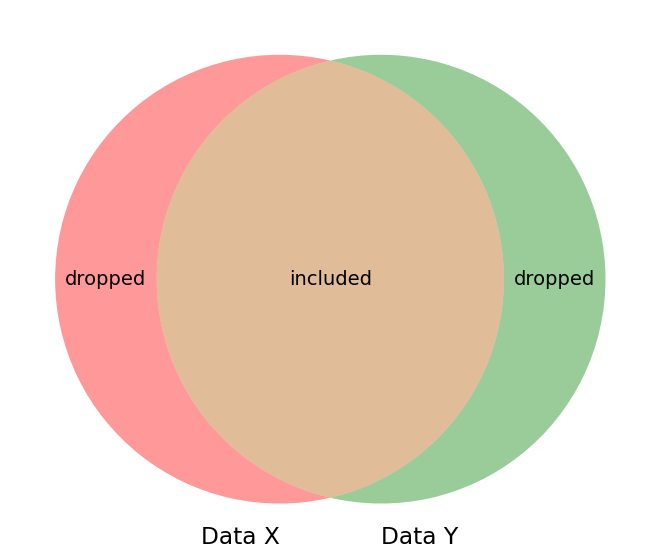

In [ ]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.